In [75]:
import os
import json
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D
# !pip install git+https://github.com/JihongJu/keras-resnet3d.git
from resnet3d import Resnet3DBuilder
from keras.callbacks import ModelCheckpoint, EarlyStopping
import SimpleITK as sitk
from skimage import filters
from sklearn import metrics as skmetrics
from scipy import interp
from itertools import cycle

In [83]:
images_data = pd.read_csv('/Users/seoyeonhong/Desktop/BIOST527/ADNI/preprocessed_images.csv')
description = pd.read_csv('/Users/seoyeonhong/Desktop/BIOST527/ADNI/ADNI_description.csv')
description = description.rename(columns = {'Image Data ID' : 'ID'})
description['ID'] = description['ID'].apply(lambda x: x[1:])
description['ID'] = description['ID'].astype('int')

In [84]:
merged_data = images_data[['ID', 'LABEL']].merge(description[['ID', 'Sex', 'Age']], how = 'left')

In [91]:
merged_data['LABEL'].value_counts()

MCI    245
CN     148
AD     118
Name: LABEL, dtype: int64

In [89]:
merged_data.groupby(['LABEL', 'Sex'])['Sex'].count()

LABEL  Sex
AD     F       53
       M       65
CN     F       77
       M       71
MCI    F       95
       M      150
Name: Sex, dtype: int64

In [88]:
merged_data.groupby('LABEL')['Age'].mean()

LABEL
AD     75.355932
CN     75.864865
MCI    74.718367
Name: Age, dtype: float64

### (1) Importing Dataset

In [2]:
# Importing Dataset

# TFRecords databases
DB_TF_PATH = '/Users/seoyeonhong/Desktop/BIOST527/ADNI/TFRecords3D/'

# Image filenames
TRAIN_PATH = DB_TF_PATH + 'train.3D.skull_stripped.tfrecords'
VAL_PATH = DB_TF_PATH + 'validation.3D.skull_stripped.tfrecords'
TEST_PATH = DB_TF_PATH + 'test.3D.skull_stripped.tfrecords'

# Path to save information about classification models
DB_MODELS = '/Users/seoyeonhong/Desktop/BIOST527/ADNI/CNN/'

In [3]:
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
N_CLASSES = len(LABELS)

IMG_SHAPE = [78, 110, 86, 1]

#TEST_SPLIT = 0.15
#VALIDATION_SPLIT = 0.15

In [4]:
# Getting number of samples

n_training_samples = 0
for record in tf.compat.v1.io.tf_record_iterator(TRAIN_PATH):
    n_training_samples += 1
print ('Training samples:', n_training_samples)

n_val_samples = 0
for record in tf.compat.v1.io.tf_record_iterator(VAL_PATH):
    n_val_samples += 1
print ('Validation samples:', n_val_samples)

n_test_samples = 0
for record in tf.compat.v1.io.tf_record_iterator(TEST_PATH):
    n_test_samples += 1
print ('Test samples:', n_test_samples)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Training samples: 370
Validation samples: 65
Test samples: 76


In [5]:
total_n_samples = n_test_samples + n_training_samples + n_val_samples
print ('Dataset size:', total_n_samples)

Dataset size: 511


In [6]:
# Reading TFRecords

def _decode(serialized_example):
    ''' Decoding TFRecords files'''
    
    # decode examples stored in TFRecord
    features = tf.io.parse_single_example(
        serialized_example,
        features = {
            'image': tf.io.FixedLenFeature(IMG_SHAPE, tf.float32),
            'label': tf.io.FixedLenFeature([], tf.int64)
        }
    )
    
    return features['image'], features['label']

SHUFFLE = 100

def parse_data(filepath, batch_size, n_classes = 3):
    ''' Using TFRecords for a Keras model'''

    # create and configure the dataset
    dataset = tf.data.TFRecordDataset(filepath).map(_decode)
    dataset = dataset.shuffle(SHUFFLE).repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1) # always have one batch ready

    # get example
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    image, label = iterator.get_next()
    
    # encode the label
    label = tf.one_hot(label, n_classes)
        
    return image, label

def get_test_data(filepath, decoding_fn):
    ''' Read test data from a TFRecord file'''

    # create the placeholders
    images = np.empty((n_test_samples, 78, 110, 86, 1))
    labels = np.empty((n_test_samples))

    # create the iterator for the TFRecord
    dataset = tf.data.TFRecordDataset(filepath).map(decoding_fn)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    
    # collect the data into placeholders
    i = 0
    while i < n_test_samples:
        images[i,], labels[i] = iterator.get_next()
        i += 1

    return images, labels

In [ ]:
def plot_auc(y_true, y_pred, target_names, title):
    n_classes = len(target_names)
    y_true = keras.utils.to_categorical(y_true, num_classes = n_classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = skmetrics.roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = skmetrics.auc(fpr[i], tpr[i])

    # compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = skmetrics.roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc['micro'] = skmetrics.auc(fpr['micro'], tpr['micro'])

    # compute macro-average ROC curve and ROC area
    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = skmetrics.auc(fpr['macro'], tpr['macro'])

    # plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(target_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(title, fontsize = 15, pad = 10)
    plt.legend(loc="lower right", fontsize = 11)

    export_file = '-'.join(title.split()) + '.png'
    plt.savefig(os.path.join(DB_MODELS, export_file))

    plt.show()


## (2) Classification

### (2)-a. Convolutional Neural Network (CNN)

In [35]:
# CNN architecture

CNN = Sequential()
CNN.add(Conv3D(32, (7, 7, 7), activation = 'relu', input_shape = IMG_SHAPE))
CNN.add(Conv3D(64, (3, 3, 3), activation='relu'))
CNN.add(Conv3D(128, (3, 3, 3), activation='relu'))
CNN.add(MaxPooling3D(pool_size=(2, 2, 2)))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
# CNN.add(Dense(256, activation='relu'))
CNN.add(Dropout(0.2))
CNN.add(Dense(N_CLASSES, activation='softmax'))

# CNN = Sequential()
# CNN.add(Conv3D(32, (5, 5, 5), activation = 'relu', input_shape = IMG_SHAPE))
# CNN.add(MaxPooling3D(pool_size=(2, 2, 2)))
# CNN.add(Dropout(0.3))
# CNN.add(Flatten())
# CNN.add(Dense(N_CLASSES, activation='softmax'))

In [10]:
# Model Compilation
CNN.compile(loss = 'categorical_crossentropy',
            optimizer = keras.optimizers.Adam(learning_rate = 0.00001),
            metrics=['accuracy'])

In [36]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_108 (Conv3D)         (None, 72, 104, 80, 32)   11008     
                                                                 
 conv3d_109 (Conv3D)         (None, 70, 102, 78, 64)   55360     
                                                                 
 conv3d_110 (Conv3D)         (None, 68, 100, 76, 128)  221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 34, 50, 38, 128)  0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 34, 50, 38, 128)   0         
                                                                 
 flatten_3 (Flatten)         (None, 8268800)           0         
                                                        

In [47]:
# Model Training

BATCH_SIZE = 16

train_images, train_labels = parse_data(TRAIN_PATH, BATCH_SIZE)
val_images, val_labels = parse_data(VAL_PATH, BATCH_SIZE)

/usr/local/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [32]:
checkpoint = ModelCheckpoint(
    'CNN-weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor = 'val_loss', 
    verbose = 1,
    save_best_only = True
    )

history = CNN.fit(x = train_images, y = train_labels, 
                  epochs = 30, validation_data = [val_images, val_labels], 
                  callbacks = [checkpoint])

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 1.1610 - accuracy: 0.1875
Epoch 1: val_loss improved from inf to 3.19643, saving model to CNN-weights.01-3.20.hdf5
1/1 [==============================] - 395s 395s/step - loss: 1.1610 - accuracy: 0.1875 - val_loss: 3.1964 - val_accuracy: 0.1875
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 1.4513 - accuracy: 0.5000
Epoch 2: val_loss improved from 3.19643 to 2.91061, saving model to CNN-weights.02-2.91.hdf5
1/1 [==============================] - 368s 368s/step - loss: 1.4513 - accuracy: 0.5000 - val_loss: 2.9106 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 1.6642 - accuracy: 0.3750
Epoch 3: val_loss improved from 2.91061 to 2.75520, saving model to CNN-weights.03-2.76.hdf5
1/1 [==============================] - 367s 367s/step - loss: 1.6642 - accuracy: 0.3750 - val_loss: 2.7552 - val_accuracy: 0.3125
Epoch 4/30
1/1 [==============================] - ETA: 0s -

Epoch 30/30
1/1 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 1.05381
1/1 [==============================] - 361s 361s/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 2.0634 - val_accuracy: 0.1875


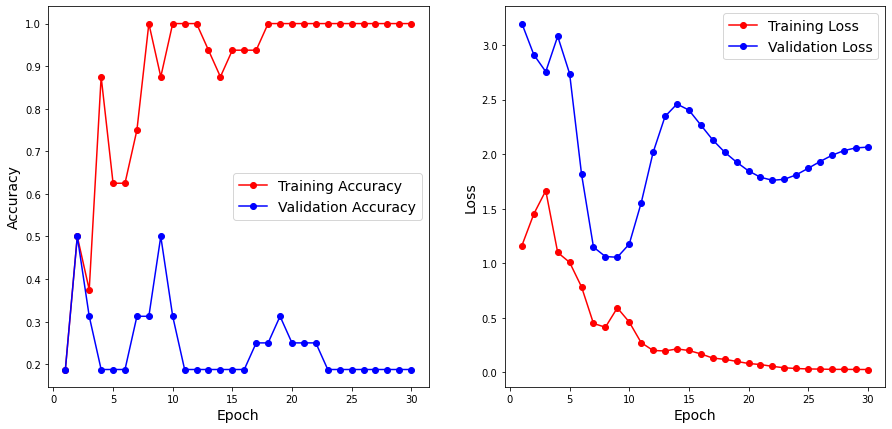

In [33]:
# Plotting Training results

epochs = range(1, 31)

figure = plt.subplots(1, 2, figsize = (15, 7))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, history.history['accuracy'], color = 'red', marker = 'o', label = 'Training Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], color = 'blue', marker = 'o', label = 'Validation Accuracy')
ax1.set_xlabel('Epoch', fontsize = 14)
ax1.set_ylabel('Accuracy', fontsize = 14)
ax1.legend(fontsize = 14)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, history.history['loss'], color = 'red', marker = 'o', label = 'Training Loss')
ax2.plot(epochs, history.history['val_loss'], color = 'blue', marker = 'o', label = 'Validation Loss')
ax2.set_xlabel('Epoch', fontsize = 14)
ax2.set_ylabel('Loss', fontsize = 14)
ax2.legend(fontsize = 14)

In [12]:
# load the weights of the best model (model.load_weights)
CNN.load_weights("CNN-weights.09-1.05.hdf5")

In [23]:
# Model Testing
# Reading test data images
# tf.compat.v1.disable_eager_execution()
test_imgs, labels = get_test_data(TEST_PATH, _decode)

In [31]:
# predicting test data
y_pred = np.empty((0, 3))

i = 0
while i < len(test_imgs):
    temp = CNN.predict(test_imgs[i:i+10])
    y_pred = np.append(y_pred, temp, axis = 0)
#     print(y_pred)
    i += 10

print(len(y_pred))

1/1 [==============================] - 10s 10s/step
76


In [37]:
# print classification report
print(skmetrics.classification_report(labels, y_pred.argmax(axis=1), target_names = LABELS))

              precision    recall  f1-score   support

          CN       0.38      0.24      0.29        25
         MCI       0.35      0.70      0.47        30
          AD       0.00      0.00      0.00        21

    accuracy                           0.36        76
   macro avg       0.24      0.31      0.25        76
weighted avg       0.26      0.36      0.28        76



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# print confusion matrix
print(skmetrics.confusion_matrix(labels, y_pred.argmax(axis=1), labels = [0, 1, 2]))

[[ 6 19  0]
 [ 9 21  0]
 [ 1 20  0]]


In [179]:
# Renaming variables so that it does not overlap 
CNN_predictions = y_pred
test_labels = labels

/var/folders/nk/4zf7bqhx64v6dj7_7shstgd40000gn/T/ipykernel_59249/2787775892.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


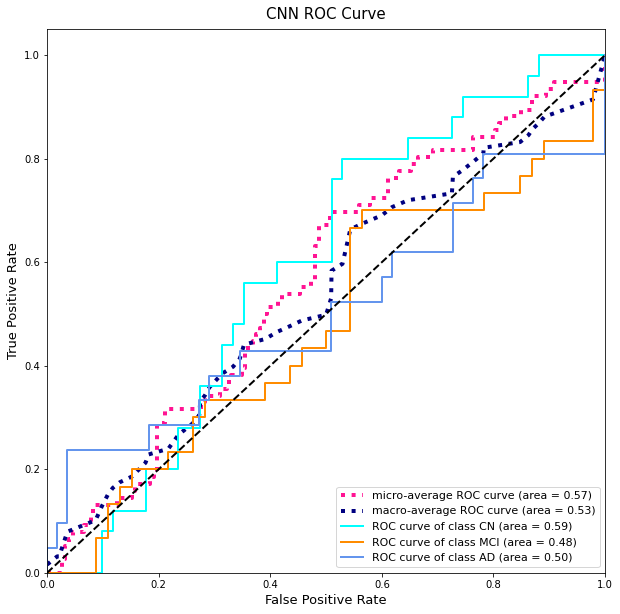

In [180]:
plot_auc(labels, CNN_predictions, ['CN', 'MCI', 'AD'], 'CNN ROC Curve')

### (2)-b. ResNet-34

In [64]:
# Model Training

BATCH_SIZE = 25

train_images, train_labels = parse_data(TRAIN_PATH, BATCH_SIZE)
val_images, val_labels = parse_data(VAL_PATH, BATCH_SIZE)

In [65]:
# https://github.com/JihongJu/keras-resnet3d

base_model = Resnet3DBuilder.build_resnet_34(
    IMG_SHAPE, N_CLASSES
)

fc_layer = tf.keras.layers.Dense(512, activation='relu')(base_model.layers[-2].output)
fc_layer = tf.keras.layers.Dropout(0.5)(fc_layer)
fc_layer = tf.keras.layers.Dropout(0.5)(fc_layer)
output_layer = tf.keras.layers.Dense(N_CLASSES, activation = 'softmax')(fc_layer)
ResNet = tf.keras.models.Model(inputs = base_model.input, outputs = output_layer)

In [66]:
ResNet.compile(loss = 'categorical_crossentropy',
               optimizer = keras.optimizers.Adam(learning_rate = 0.00005),
               metrics=['accuracy'])

In [67]:
ResNet.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 78, 110, 86  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_211 (Conv3D)            (None, 39, 55, 43,   22016       ['input_9[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_184 (Batch  (None, 39, 55, 43,   256        ['conv3d_211[0][0]']             
 Normalization)                 64)                                                        

                                                                                                  
 batch_normalization_191 (Batch  (None, 10, 14, 11,   512        ['conv3d_218[0][0]']             
 Normalization)                 128)                                                              
                                                                                                  
 activation_191 (Activation)    (None, 10, 14, 11,   0           ['batch_normalization_191[0][0]']
                                128)                                                              
                                                                                                  
 conv3d_220 (Conv3D)            (None, 10, 14, 11,   8320        ['add_90[0][0]']                 
                                128)                                                              
                                                                                                  
 conv3d_21

                                128)                                                              
                                                                                                  
 conv3d_227 (Conv3D)            (None, 5, 7, 6, 256  884992      ['activation_198[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_199 (Batch  (None, 5, 7, 6, 256  1024       ['conv3d_227[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activation_199 (Activation)    (None, 5, 7, 6, 256  0           ['batch_normalization_199[0][0]']
                                )                                                                 
          

 batch_normalization_206 (Batch  (None, 5, 7, 6, 256  1024       ['add_98[0][0]']                 
 Normalization)                 )                                                                 
                                                                                                  
 activation_206 (Activation)    (None, 5, 7, 6, 256  0           ['batch_normalization_206[0][0]']
                                )                                                                 
                                                                                                  
 conv3d_236 (Conv3D)            (None, 5, 7, 6, 256  1769728     ['activation_206[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_207 (Batch  (None, 5, 7, 6, 256  1024       ['conv3d_236[0][0]']             
 Normaliza

                                                                                                  
 add_102 (Add)                  (None, 3, 4, 3, 512  0           ['add_101[0][0]',                
                                )                                 'conv3d_244[0][0]']             
                                                                                                  
 batch_normalization_214 (Batch  (None, 3, 4, 3, 512  2048       ['add_102[0][0]']                
 Normalization)                 )                                                                 
                                                                                                  
 activation_214 (Activation)    (None, 3, 4, 3, 512  0           ['batch_normalization_214[0][0]']
                                )                                                                 
                                                                                                  
 conv3d_24

In [68]:
# checkpoint = ModelCheckpoint(
#     'ResNet-weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#     monitor = 'val_loss', 
#     verbose = 1,
#     save_best_only = True
#     )

# ResNet_history = ResNet.fit(x = train_images, y = train_labels, 
#                             epochs = 25, validation_data = [val_images, val_labels], 
#                             callbacks = [checkpoint])

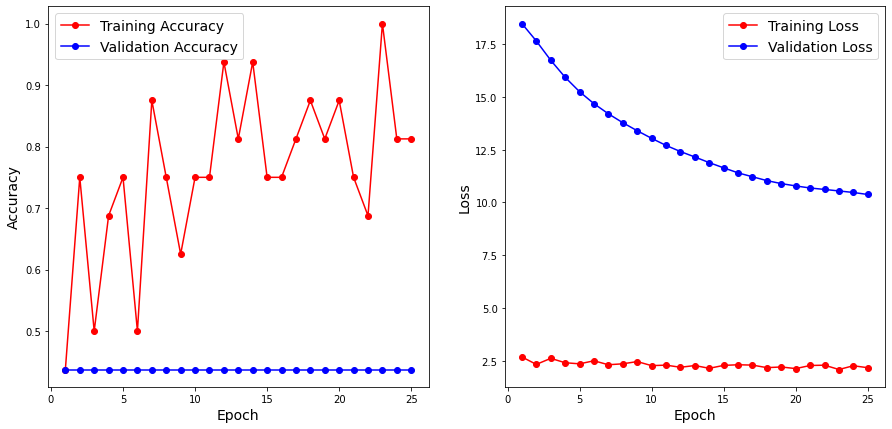

In [82]:
# Plotting Training results
# First attempt

epochs = range(1, 26)

figure = plt.subplots(1, 2, figsize = (15, 7))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, ResNet_history.history['accuracy'], color = 'red', marker = 'o', label = 'Training Accuracy')
ax1.plot(epochs, ResNet_history.history['val_accuracy'], color = 'blue', marker = 'o', label = 'Validation Accuracy')
ax1.set_xlabel('Epoch', fontsize = 14)
ax1.set_ylabel('Accuracy', fontsize = 14)
ax1.legend(fontsize = 14)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, ResNet_history.history['loss'], color = 'red', marker = 'o', label = 'Training Loss')
ax2.plot(epochs, ResNet_history.history['val_loss'], color = 'blue', marker = 'o', label = 'Validation Loss')
ax2.set_xlabel('Epoch', fontsize = 14)
ax2.set_ylabel('Loss', fontsize = 14)
ax2.legend(fontsize = 14)

In [71]:
# second attempt with bigger learning rate, bigger batch size, extra dropout layer

checkpoint = ModelCheckpoint(
    'ResNet-weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = False
    )

ResNet_history = ResNet.fit(x = train_images, y = train_labels,
                            epochs = 20, validation_data = [val_images, val_labels], 
                            callbacks = [checkpoint])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2.5946 - accuracy: 0.6000
Epoch 1: saving model to ResNet-weights.01-38.38.hdf5
1/1 [==============================] - 90s 90s/step - loss: 2.5946 - accuracy: 0.6000 - val_loss: 38.3817 - val_accuracy: 0.3200
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2.6422 - accuracy: 0.4800
Epoch 2: saving model to ResNet-weights.02-39.49.hdf5
1/1 [==============================] - 88s 88s/step - loss: 2.6422 - accuracy: 0.4800 - val_loss: 39.4881 - val_accuracy: 0.3200
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 2.4851 - accuracy: 0.6800
Epoch 3: saving model to ResNet-weights.03-40.01.hdf5
1/1 [==============================] - 88s 88s/step - loss: 2.4851 - accuracy: 0.6800 - val_loss: 40.0089 - val_accuracy: 0.4000
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 2.3428 - accuracy: 0.8000
Epoch 4: saving model to ResNet-weights.04-39.54.hdf5
1/1 [========================

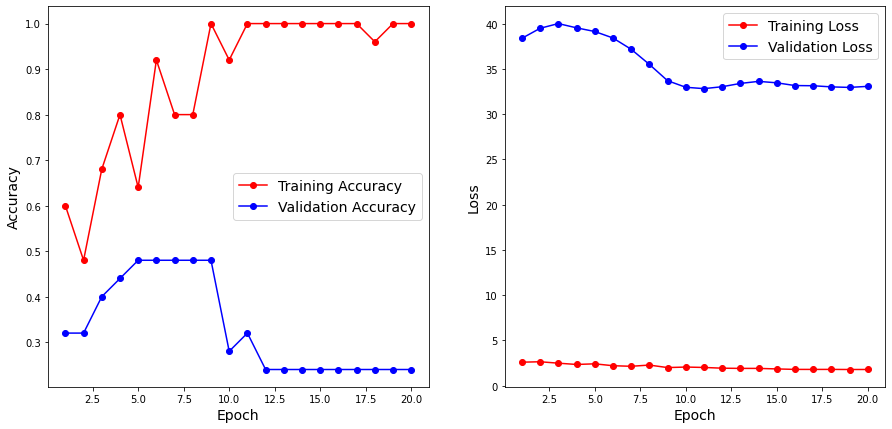

In [73]:
# Plotting Training results

epochs = range(1, 21)

figure = plt.subplots(1, 2, figsize = (15, 7))
 
ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, ResNet_history.history['accuracy'], color = 'red', marker = 'o', label = 'Training Accuracy')
ax1.plot(epochs, ResNet_history.history['val_accuracy'], color = 'blue', marker = 'o', label = 'Validation Accuracy')
ax1.set_xlabel('Epoch', fontsize = 14)
ax1.set_ylabel('Accuracy', fontsize = 14)
ax1.legend(fontsize = 14)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, ResNet_history.history['loss'], color = 'red', marker = 'o', label = 'Training Loss')
ax2.plot(epochs, ResNet_history.history['val_loss'], color = 'blue', marker = 'o', label = 'Validation Loss')
ax2.set_xlabel('Epoch', fontsize = 14)
ax2.set_ylabel('Loss', fontsize = 14)
ax2.legend(fontsize = 14)

In [92]:
# load the weights of the best model (model.load_weights)
ResNet.load_weights("ResNet-weights.08-35.50.hdf5")

In [93]:
# predicting test data
ResNet_y_pred = np.empty((0, 3))

i = 0
while i < len(test_imgs):
    temp = ResNet.predict(test_imgs[i:i+10])
    ResNet_y_pred = np.append(ResNet_y_pred, temp, axis = 0)
#     print(y_pred)
    i += 10

print(len(ResNet_y_pred))

/usr/local/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
76


In [94]:
# print classification report
print(skmetrics.classification_report(labels, ResNet_y_pred.argmax(axis=1), target_names = LABELS))

              precision    recall  f1-score   support

          CN       0.00      0.00      0.00        25
         MCI       0.40      1.00      0.57        30
          AD       0.00      0.00      0.00        21

    accuracy                           0.39        76
   macro avg       0.13      0.33      0.19        76
weighted avg       0.16      0.39      0.23        76



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
# print confusion matrix
print(skmetrics.confusion_matrix(labels, ResNet_y_pred.argmax(axis=1), labels = [0, 1, 2]))

[[ 0 24  1]
 [ 0 30  0]
 [ 0 21  0]]


/var/folders/nk/4zf7bqhx64v6dj7_7shstgd40000gn/T/ipykernel_67999/2787775892.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


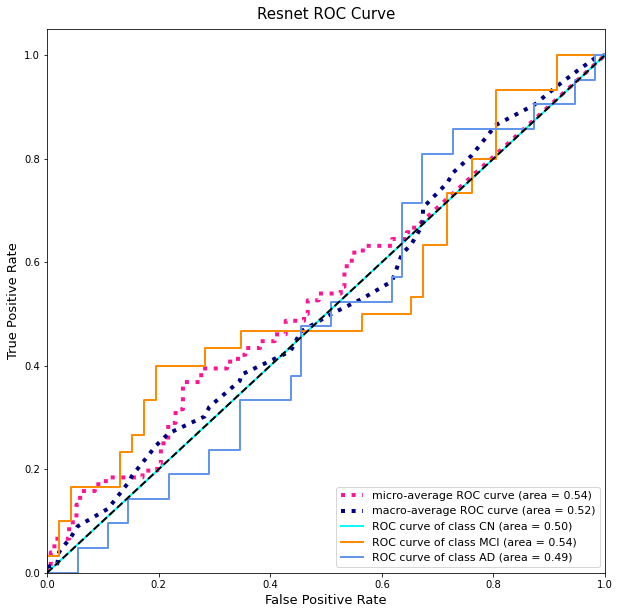

In [96]:
plot_auc(labels, ResNet_y_pred, ['CN', 'MCI', 'AD'], 'Resnet ROC Curve')

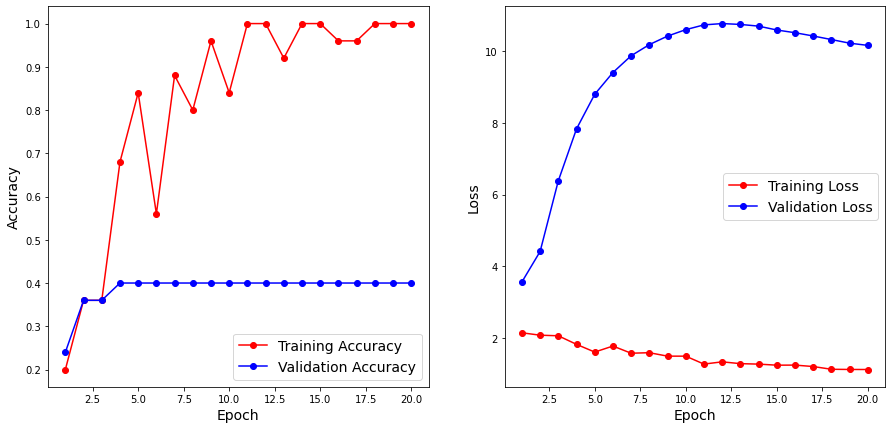

In [62]:
# Plotting Training results ResNet-18

epochs = range(1, 21)

figure = plt.subplots(1, 2, figsize = (15, 7))
 
ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, ResNet_history.history['accuracy'], color = 'red', marker = 'o', label = 'Training Accuracy')
ax1.plot(epochs, ResNet_history.history['val_accuracy'], color = 'blue', marker = 'o', label = 'Validation Accuracy')
ax1.set_xlabel('Epoch', fontsize = 14)
ax1.set_ylabel('Accuracy', fontsize = 14)
ax1.legend(fontsize = 14)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, ResNet_history.history['loss'], color = 'red', marker = 'o', label = 'Training Loss')
ax2.plot(epochs, ResNet_history.history['val_loss'], color = 'blue', marker = 'o', label = 'Validation Loss')
ax2.set_xlabel('Epoch', fontsize = 14)
ax2.set_ylabel('Loss', fontsize = 14)
ax2.legend(fontsize = 14)